In [1]:
from qiskit_gym.envs import LinearFunctionGym, CliffordGym, PermutationGym, LinearFunctionNoisyGym
from qiskit_gym.rl import RLSynthesis, PPOConfig, AlphaZeroConfig, BasicPolicyConfig


from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
import numpy as np

In [2]:
cmap_6_line = CouplingMap.from_ring(5, bidirectional=True)
env = LinearFunctionNoisyGym.from_coupling_map(cmap_6_line, basis_gates=["CX", 'SWAP'])
env2 = LinearFunctionGym.from_coupling_map(cmap_6_line, basis_gates= ['CX', 'SWAP'])

rls = RLSynthesis(env, PPOConfig(), BasicPolicyConfig())
rls.learn(initial_difficulty=3, num_iterations=10, tb_path="runs/lf_4_line_ppo/")  # This will track progress in Tensorboard

rls.env.config['gateset']

rls2 = RLSynthesis(env2, PPOConfig(), BasicPolicyConfig())
rls2.learn(num_iterations=10, tb_path="runs/lf_4_line_ppo/")  # This will track progress in Tensorboard


2025-12-07 17:23:15.233 | INFO     | twisterl.rl.algorithm:learn:176 - (3/0) {'successes': {'ppo_deterministic': 0.0, 'ppo_10': 0.10999999940395355}, 'rewards': {'ppo_deterministic': -0.8522070050239563, 'ppo_10': -0.41316404938697815}, 'difficulty': 3, 'success': 0.0, 'reward': -0.8522070050239563} | {'to_rust': 0.003908208, 'eval_ppo_deterministic': 0.0023695, 'eval_ppo_10': 0.019597958, 'collect': 0.026149125, 'data_to_torch': 0.034730792, 'train': 0.356749125, 'total': 0.444397958}
2025-12-07 17:23:15.652 | INFO     | twisterl.rl.algorithm:learn:176 - (3/1) {'successes': {'ppo_deterministic': 0.009999999776482582, 'ppo_10': 0.10000000149011612}, 'rewards': {'ppo_deterministic': -0.8367695808410645, 'ppo_10': -0.42533203959465027}, 'difficulty': 3, 'success': 0.009999999776482582, 'reward': -0.8367695808410645} | {'to_rust': 0.005885584, 'eval_ppo_deterministic': 0.002430917, 'eval_ppo_10': 0.103800583, 'collect': 0.039094834, 'data_to_torch': 0.020491792, 'train': 0.223989792, 'tot

In [3]:
rls.env.config['gateset']

[('CX', (0, 1)),
 ('CX', (0, 4)),
 ('CX', (1, 0)),
 ('CX', (1, 2)),
 ('CX', (2, 1)),
 ('CX', (2, 3)),
 ('CX', (3, 2)),
 ('CX', (3, 4)),
 ('CX', (4, 0)),
 ('CX', (4, 3)),
 ('SWAP', (0, 1)),
 ('SWAP', (0, 4)),
 ('SWAP', (1, 0)),
 ('SWAP', (1, 2)),
 ('SWAP', (2, 1)),
 ('SWAP', (2, 3)),
 ('SWAP', (3, 2)),
 ('SWAP', (3, 4)),
 ('SWAP', (4, 0)),
 ('SWAP', (4, 3))]

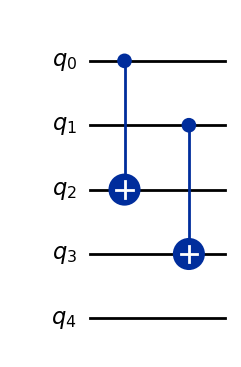

In [4]:

from qiskit.circuit.library.generalized_gates import LinearFunction
qc_lf_input = QuantumCircuit(5)

# qc_lf_input.cx(0,3)

# qc_lf_input.cx(0,5)
qc_lf_input.cx(0,2)
qc_lf_input.cx(1,3)
# qc_lf_input.cx(2,4)

# qc_lf_input.cx(6,4)
# qc_lf_input.cx(2,1)
# qc_lf_input.cx(3,1)
# qc_lf_input.cx(0,1)
# qc_lf_input.cx(0,2)
# qc_lf_input.cx(0,3)
# qc_lf_input.cx(0,3)
# qc_lf_input.cx(0,2)
# qc_lf_input.cx(0,3)
qc_lf_input.draw(fold=-1, output="mpl")

Noisy Synthesis


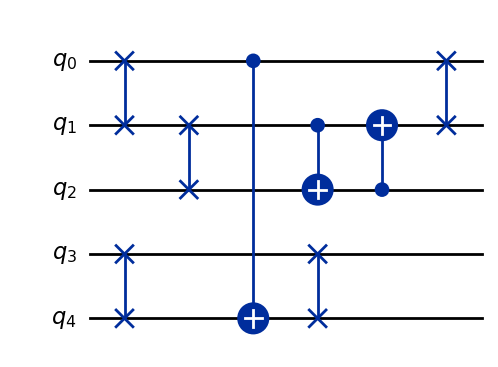

In [24]:
print('Noisy Synthesis')

qc_lf_output = rls.synth(qc_lf_input, num_searches=3000, num_mcts_searches=0, deterministic=False)


# while qc_lf_output is None:
#     qc_lf_output = rls.synth(qc_lf_input, num_searches=1000, num_mcts_searches=0, deterministic=False)

qc_lf_output.draw(fold=-1, output ='mpl',)

not noisy


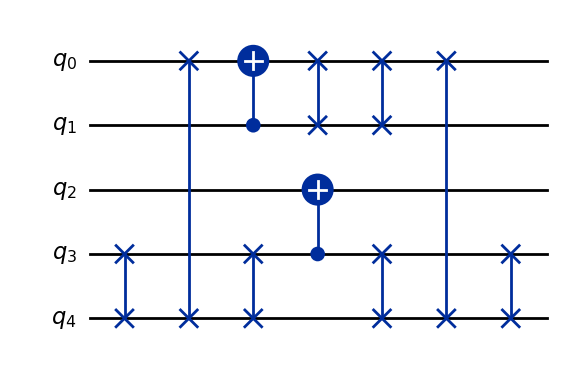

In [22]:
print('not noisy')
qc_lf_output2 = rls2.synth(qc_lf_input, num_searches=2000, num_mcts_searches=0, deterministic=False)
qc_lf_output2.draw(fold=-1, output = 'mpl')

In [ ]:
from qiskit import transpile, generate_preset_pass_manager

from qiskit import QuantumCircuit
# from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashingtonV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.coupling import CouplingMap
 
# backend = FakeAuckland()
cmap_6_line = CouplingMap.from_ring(5, bidirectional=True)
 

ghz = QuantumCircuit(5)
ghz.cx(0,4)
 
depths = []
pass_manager = generate_preset_pass_manager(
        coupling_map=cmap_6_line,
        optimization_level=1,
        routing_method="sabre",
        layout_method="trivial",  # Fixed layout mapped in circuit order
)

# ghz.draw()
ghz.draw()
pass_manager.run(ghz).draw()


q_0 -> 0 ──■──
         ┌─┴─┐
q_4 -> 4 ┤ X ├
         └───┘

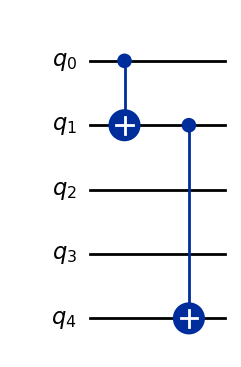

In [26]:
import random


def generate_random_circ(num_qubits):
    qc = QuantumCircuit(num_qubits)
    for i in range(random.randrange(2, 3)):
        q1 = random.randint(0, num_qubits - 1)
        q2 = q1 + (2 * random.randint(-1, 1)) 
        if q1 == q2 :
            q2 = q1 + 1
        if  q2 >= num_qubits:
            q2 = q1 - 2
        qc.cx(q1,q2)

    return qc
    
    


qc = generate_random_circ(5)
qc.draw(fold=-1, output="mpl")


In [27]:
# qc_lf_output2.count_ops()
# for val in qc_lf_output2.decompose().data:
#     print(val)

#parrsing data to show 
#make another hash map to represent edges on map
#then add for each op one onto the location in the map
#then multiply by noise factor
#then run this multiple times and find the AVERAGE accross each edge and compare to the noisy version to see if there is a difference in the noise accumulation
map1 = {}
map2 = {}
for _ in range(10):
    # qc_lf_output = rls.synth(qc_lf_input, num_searches=3000, num_mcts_searches=0, deterministic=False)
    qc_input = generate_random_circ(5)
    qc_lf_output = rls.synth(qc_input, num_searches=3000, num_mcts_searches=0, deterministic=False)
    while qc_lf_output is None:
        qc_lf_output = rls.synth(qc_lf_input, num_searches=3000, num_mcts_searches=0, deterministic=False)

    for val in qc_lf_output.decompose().data:
        edge =  sorted([val.qubits[0]._index, val.qubits[1]._index])
        edge = tuple(edge)
        if edge not in map1:
            map1[edge] = 1
        else:
            map1[edge] += 1
    
    qc_lf_output2 = rls2.synth(qc_input, num_searches=1000, num_mcts_searches=0, deterministic=False)
    while qc_lf_output2 is None:
        qc_lf_output2 = rls2.synth(qc_input, num_searches=1000, num_mcts_searches=0, deterministic=False)

    for val in qc_lf_output2.decompose().data:
        edge =  sorted([val.qubits[0]._index, val.qubits[1]._index])
        edge = tuple(edge)
        if edge not in map2:
            map2[edge] = 1
        else:
            map2[edge] += 1

# for val in map2:
#     map2[val] /= 10

print(map1)
print(map2)

{(0, 1): 29, (2, 3): 35, (3, 4): 16, (1, 2): 42, (0, 4): 9}
{(2, 3): 30, (1, 2): 39, (3, 4): 56, (0, 1): 31, (0, 4): 29}


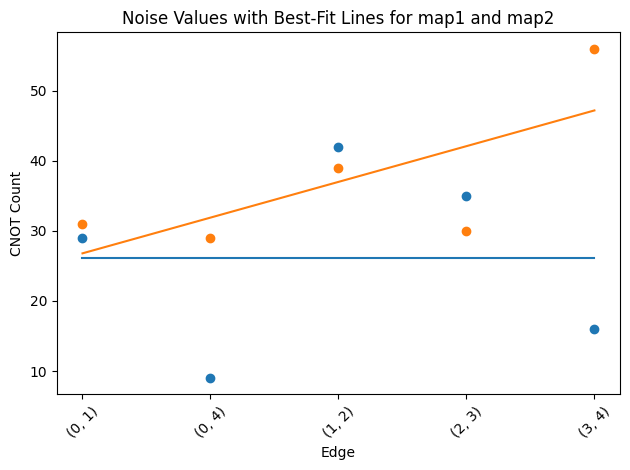

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort edges for consistent x-axis
edges = sorted(map1.keys())
x = np.arange(len(edges))

y1 = np.array([map1[e] for e in edges])
y2 = np.array([map2[e] for e in edges])

# Best-fit lines
m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)

plt.figure()

plt.scatter(x, y1)
plt.plot(x, m1 * x + b1)

plt.scatter(x, y2)
plt.plot(x, m2 * x + b2)

plt.xlabel("Edge")
plt.ylabel("CNOT Count")
plt.title("CNOT Distribution with Best-Fit Lines")
plt.xticks(x, [str(e) for e in edges], rotation=45)

plt.tight_layout()
plt.show()


In [10]:
from qiskit.circuit.library.generalized_gates import LinearFunction
LinearFunction(qc_lf_input) == LinearFunction(qc_lf_output)

np.True_

In [ ]:
cmap_3_line = CouplingMap.from_line(3, bidirectional=True)
cmap = CouplingMap.from_grid(3,3,bidirectional=True)
env = LinearFunctionNoisyGym.from_coupling_map(cmap)
print(env.config["gateset"])



some_perm = np.random.permutation(9)

rls = RLSynthesis(env, PPOConfig(), BasicPolicyConfig())

rls.env.config["gateset"]

qc_perm = rls.synth(some_perm, num_searches=1000)
qc_perm.draw(fold=-1)


[('CX', (0, 1)), ('CX', (0, 3)), ('CX', (1, 0)), ('CX', (1, 2)), ('CX', (1, 4)), ('CX', (2, 1)), ('CX', (2, 5)), ('CX', (3, 0)), ('CX', (3, 4)), ('CX', (3, 6)), ('CX', (4, 1)), ('CX', (4, 3)), ('CX', (4, 5)), ('CX', (4, 7)), ('CX', (5, 2)), ('CX', (5, 4)), ('CX', (5, 8)), ('CX', (6, 3)), ('CX', (6, 7)), ('CX', (7, 4)), ('CX', (7, 6)), ('CX', (7, 8)), ('CX', (8, 5)), ('CX', (8, 7)), ('SWAP', (0, 1)), ('SWAP', (0, 3)), ('SWAP', (1, 0)), ('SWAP', (1, 2)), ('SWAP', (1, 4)), ('SWAP', (2, 1)), ('SWAP', (2, 5)), ('SWAP', (3, 0)), ('SWAP', (3, 4)), ('SWAP', (3, 6)), ('SWAP', (4, 1)), ('SWAP', (4, 3)), ('SWAP', (4, 5)), ('SWAP', (4, 7)), ('SWAP', (5, 2)), ('SWAP', (5, 4)), ('SWAP', (5, 8)), ('SWAP', (6, 3)), ('SWAP', (6, 7)), ('SWAP', (7, 4)), ('SWAP', (7, 6)), ('SWAP', (7, 8)), ('SWAP', (8, 5)), ('SWAP', (8, 7))]


AttributeError: 'numpy.ndarray' object has no attribute 'linear'

In [ ]:
# You can set a custom state like this (in this case from a circuit)
env.set_state(env.get_state(qc))

env.action_space  # This tells you the number of possible actions (a discrete space of 8 actions)

env.observation_space  # This tells you the type and size of observation space (N by N discrete in this case)

# You can advance the env by providing an action
obs, reward, is_final, _, _ = env.step(2)

# This provides:
# - The observation of the state right after action
# - The reward for that step
# - If we are in a final state

obs, reward, is_final


# One way to do it
env.set_state(env.get_state(qc))
env.render()
for a in [4,2,4]:
    print(f"[{a}] - {env.config['gateset'][a]}")
    obs, reward, is_final, _, _ = env.step(a)
    print(f"[{a}] - Reward: {reward}, Is final: {is_final}")
    env.render()

[[1 0 0]
 [0 1 0]
 [1 0 1]]
[4] - ('SWAP', (0, 1))
[4] - Reward: -0.0062500000931322575, Is final: False
[[0 1 0]
 [1 0 0]
 [1 0 1]]
[2] - ('CX', (1, 2))
[2] - Reward: -0.0054687499068677425, Is final: False
[[0 1 0]
 [1 0 0]
 [0 0 1]]
[4] - ('SWAP', (0, 1))
[4] - Reward: 1.0, Is final: True
[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [ ]:
cmap_3x3 = CouplingMap.from_grid(3,3, bidirectional=False)
env = PermutationGym.from_coupling_map(cmap_3x3)
rls = RLSynthesis(env, PPOConfig(), BasicPolicyConfig())

rls.env.config["gateset"]

[('SWAP', (0, 1)),
 ('SWAP', (0, 3)),
 ('SWAP', (1, 2)),
 ('SWAP', (1, 4)),
 ('SWAP', (2, 5)),
 ('SWAP', (3, 4)),
 ('SWAP', (3, 6)),
 ('SWAP', (4, 5)),
 ('SWAP', (4, 7)),
 ('SWAP', (5, 8)),
 ('SWAP', (6, 7)),
 ('SWAP', (7, 8))]

In [ ]:
rls.learn(num_iterations=10, tb_path="runs/perm_square_3x3/")

2025-09-19 09:59:05.237 | INFO     | twisterl.rl.algorithm:learn:176 - (1/0) {'successes': {'ppo_deterministic': 0.0, 'ppo_10': 0.5199999809265137}, 'rewards': {'ppo_deterministic': -0.5078125, 'ppo_10': 0.27421873807907104}, 'difficulty': 1, 'success': 0.0, 'reward': -0.5078125} | {'to_rust': 0.00404725, 'eval_ppo_deterministic': 0.001655167, 'eval_ppo_10': 0.008290458, 'collect': 0.014999666, 'data_to_torch': 0.041117209, 'train': 0.17895525, 'total': 0.249390875}
2025-09-19 09:59:05.244 | INFO     | twisterl.rl.algorithm:learn:196 - (1/0) Improved, saved checkpoint!
2025-09-19 09:59:05.389 | INFO     | twisterl.rl.algorithm:learn:176 - (1/1) {'successes': {'ppo_deterministic': 0.11999999731779099, 'ppo_10': 0.5699999928474426}, 'rewards': {'ppo_deterministic': -0.32734376192092896, 'ppo_10': 0.34941405057907104}, 'difficulty': 1, 'success': 0.11999999731779099, 'reward': -0.32734376192092896} | {'to_rust': 0.003409833, 'eval_ppo_deterministic': 0.001171125, 'eval_ppo_10': 0.00860720

In [ ]:
#rls.save("models/perm_square_3x3.json", "models/perm_square_3x3.pt")

rls = RLSynthesis.from_config_json("models/perm_square_3x3.json", "models/perm_square_3x3.pt")

In [ ]:
some_perm = np.random.permutation(9)

qc_perm = rls.synth(some_perm, num_searches=1000, num_mcts_searches=0, deterministic=False)
qc_perm.draw(fold=-1)



q_0: ─────────────X─
                  │ 
q_1: ─X────────X──X─
      │        │    
q_2: ─X────────┼────
               │    
q_3: ─X─────X──┼──X─
      │     │  │  │ 
q_4: ─X──X──┼──X──X─
         │  │       
q_5: ────X──┼───────
            │       
q_6: ───────X───────
                    
q_7: ─X─────────────
      │             
q_8: ─X─────────────

In [ ]:
qc_perm_input = QuantumCircuit(9)
qc_perm_input.swap(0,8)
qc_perm_input.draw(fold=-1)

q_0: ─X─
      │ 
q_1: ─┼─
      │ 
q_2: ─┼─
      │ 
q_3: ─┼─
      │ 
q_4: ─┼─
      │ 
q_5: ─┼─
      │ 
q_6: ─┼─
      │ 
q_7: ─┼─
      │ 
q_8: ─X─

In [ ]:
qc_perm_output = rls.synth(qc_perm_input, num_searches=1000, num_mcts_searches=0, deterministic=False)
qc_perm_output.draw(fold=-1)

cmap = CouplingMap.from_heavy_hex(9, bidirectional=True)
env = LinearFunctionNoisyGym.from_coupling_map(cmap)
env.config["gateset"]

[('CX', (0, 81)),
 ('CX', (0, 121)),
 ('CX', (1, 121)),
 ('CX', (1, 122)),
 ('CX', (2, 122)),
 ('CX', (2, 123)),
 ('CX', (3, 123)),
 ('CX', (3, 124)),
 ('CX', (4, 124)),
 ('CX', (4, 125)),
 ('CX', (5, 125)),
 ('CX', (5, 126)),
 ('CX', (6, 126)),
 ('CX', (6, 127)),
 ('CX', (7, 127)),
 ('CX', (7, 128)),
 ('CX', (8, 128)),
 ('CX', (9, 81)),
 ('CX', (9, 129)),
 ('CX', (10, 129)),
 ('CX', (10, 130)),
 ('CX', (11, 130)),
 ('CX', (11, 131)),
 ('CX', (12, 131)),
 ('CX', (12, 132)),
 ('CX', (13, 132)),
 ('CX', (13, 133)),
 ('CX', (14, 133)),
 ('CX', (14, 134)),
 ('CX', (15, 134)),
 ('CX', (15, 135)),
 ('CX', (16, 135)),
 ('CX', (16, 136)),
 ('CX', (17, 90)),
 ('CX', (17, 136)),
 ('CX', (18, 91)),
 ('CX', (18, 137)),
 ('CX', (19, 137)),
 ('CX', (19, 138)),
 ('CX', (20, 138)),
 ('CX', (20, 139)),
 ('CX', (21, 139)),
 ('CX', (21, 140)),
 ('CX', (22, 140)),
 ('CX', (22, 141)),
 ('CX', (23, 141)),
 ('CX', (23, 142)),
 ('CX', (24, 142)),
 ('CX', (24, 143)),
 ('CX', (25, 143)),
 ('CX', (25, 144)),
 ('

In [ ]:
#rls.save("models/lf_5_line.json", "models/lf_5_line.pt")

rls = RLSynthesis.from_config_json("models/lf_5_line.json", "models/lf_5_line.pt")

In [ ]:
qc_lf_input = QuantumCircuit(5)
qc_lf_input.cx(0,4)
qc_lf_input.draw(fold=-1)

q_0: ──■──
       │  
q_1: ──┼──
       │  
q_2: ──┼──
       │  
q_3: ──┼──
     ┌─┴─┐
q_4: ┤ X ├
     └───┘

In [ ]:
qc_lf_output = rls.synth(qc_lf_input, num_searches=1000, num_mcts_searches=0, deterministic=False)
qc_lf_output.draw(fold=-1)

q_0: ───────■───────────────────■──────────────────────
          ┌─┴─┐               ┌─┴─┐                    
q_1: ──■──┤ X ├──■─────────■──┤ X ├──■─────────────────
     ┌─┴─┐└───┘┌─┴─┐     ┌─┴─┐└───┘┌─┴─┐               
q_2: ┤ X ├─────┤ X ├──■──┤ X ├─────┤ X ├──■────────────
     ├───┤     └───┘┌─┴─┐└───┘     └───┘┌─┴─┐     ┌───┐
q_3: ┤ X ├──■───────┤ X ├───────────────┤ X ├──■──┤ X ├
     └─┬─┘┌─┴─┐     └───┘               └───┘┌─┴─┐└─┬─┘
q_4: ──■──┤ X ├──────────────────────────────┤ X ├──■──
          └───┘                              └───┘

In [ ]:
from qiskit.circuit.library.generalized_gates import LinearFunction
LinearFunction(qc_lf_input) == LinearFunction(qc_lf_output)

np.True_

In [ ]:
# Here we want to do Clifford synthesis but we only allow H and S to be placed on qubit 0
env = CliffordGym(
    num_qubits=3, 
    gateset=[
        ("CX", [0,1]),
        ("CX", [1,0]),
        ("CX", [1,2]),
        ("CX", [2,1]),
        ("SWAP", [0,1]),
        ("SWAP", [1,2]),
        ("H", [0]),
        ("S", [0]),
    ]
)
rls = RLSynthesis(env, PPOConfig(), BasicPolicyConfig())
rls.learn(num_iterations=10, tb_path="runs/clifford_3q_custom/")

2025-09-19 10:50:25.274 | INFO     | twisterl.rl.algorithm:learn:176 - (1/0) {'successes': {'ppo_deterministic': 0.10999999940395355, 'ppo_10': 0.7300000190734863}, 'rewards': {'ppo_deterministic': -0.3423828184604645, 'ppo_10': 0.590039074420929}, 'difficulty': 1, 'success': 0.10999999940395355, 'reward': -0.3423828184604645} | {'to_rust': 0.00384125, 'eval_ppo_deterministic': 0.001390083, 'eval_ppo_10': 0.006526708, 'collect': 0.010808792, 'data_to_torch': 0.009190958, 'train': 0.109077416, 'total': 0.141090083}
2025-09-19 10:50:25.279 | INFO     | twisterl.rl.algorithm:learn:196 - (1/0) Improved, saved checkpoint!
2025-09-19 10:50:25.421 | INFO     | twisterl.rl.algorithm:learn:176 - (1/1) {'successes': {'ppo_deterministic': 0.14000000059604645, 'ppo_10': 0.6700000166893005}, 'rewards': {'ppo_deterministic': -0.2972656190395355, 'ppo_10': 0.49980467557907104}, 'difficulty': 1, 'success': 0.14000000059604645, 'reward': -0.2972656190395355} | {'to_rust': 0.002984708, 'eval_ppo_determi

In [ ]:
#rls.save("models/clifford_3q_custom.json", "models/clifford_3q_custom.pt")

rls = RLSynthesis.from_config_json("models/clifford_3q_custom.json", "models/clifford_3q_custom.pt")

In [ ]:
from qiskit.quantum_info import random_clifford, Clifford

In [ ]:
qc_clifford_in = QuantumCircuit(3)
qc_clifford_in.h(2)

qc_clifford_out = rls.synth(qc_clifford_in, num_searches=1000, num_mcts_searches=0, deterministic=False)
qc_clifford_out.draw(fold=-1)

┌───┐           
q_0: ────X─┤ H ├─X──────■──
         │ └───┘ │    ┌─┴─┐
q_1: ─X──X───■───X──X─┤ X ├
      │    ┌─┴─┐    │ └───┘
q_2: ─X────┤ X ├────X──────
           └───┘

In [ ]:
some_clifford = random_clifford(3, seed=42)
qc_rand_clifford_out = rls.synth(some_clifford, num_searches=1000, num_mcts_searches=0, deterministic=False)
qc_rand_clifford_out.draw(fold=-1)

┌───┐┌───┐   ┌───┐┌───┐┌───┐                        ┌───┐┌───┐          ┌───┐┌───┐                ┌───┐┌───┐┌───┐   ┌───┐┌───┐   ┌───┐   ┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐        ┌───┐┌───┐┌───┐┌───┐                ┌───┐┌───┐                                 ┌───┐   ┌───┐        ┌───┐                                 ┌───┐      ┌───┐             ┌───┐┌───┐   ┌───┐                      ┌───┐┌───┐      ┌───┐                     ┌───┐            ┌───┐        
q_0: ┤ S ├┤ H ├───┤ X ├┤ X ├┤ H ├────────────X────────■──┤ X ├┤ H ├──────────┤ X ├┤ H ├──────────────X─┤ X ├┤ S ├┤ H ├─X─┤ H ├┤ H ├─X─┤ H ├─X─┤ H ├┤ H ├┤ X ├──────────┤ X ├┤ S ├┤ S ├──────X─┤ H ├┤ H ├┤ X ├┤ X ├──■───────■─────┤ X ├┤ S ├─────────────────■───X───■───────┤ X ├─X─┤ S ├─X───■──┤ H ├────────────■────■────────────■──┤ H ├──────┤ X ├──────X───■──┤ H ├┤ S ├─X─┤ H ├─X──────■───X──────■──┤ H ├┤ H ├─X────┤ X ├──────X──X────────■──┤ S ├──────────X─┤ H ├────────
     ├───┤└───┘   └─┬─┘└─┬─┘├───┤   ┌───┐    │      ┌─┴─┐└─┬─┘├───┤┌───┐┌───┐└─┬─┘└───┘              │ └─┬─┘└───┘└───┘ │ ├───┤└───┘ │ └───┘ │ └───┘└───┘└─┬─┘┌───┐┌───┐└─┬─┘└───┘└───┘      │ ├───┤└───┘└─┬─┘└─┬─┘┌─┴─┐   ┌─┴─┐   └─┬─┘├───┤               ┌─┴─┐ │ ┌─┴─┐┌───┐└─┬─┘ │ └───┘ │ ┌─┴─┐└───┘┌───┐┌───┐┌─┴─┐┌─┴─┐        ┌─┴─┐└───┘      └─┬─┘      │ ┌─┴─┐└───┘└───┘ │ ├───┤ │    ┌─┴─┐ │    ┌─┴─┐├───┤└───┘ │    └─┬─┘      │  │ ┌───┐┌─┴─┐└───┘          │ └───┘        
q_1: ┤ X ├──X───X───■────■──┤ X ├─X─┤ X ├─X──X───■──┤ X ├──■──┤ X ├┤ X ├┤ X ├──■────■───X───■────■───X───■────■────────X─┤ X ├──────X───────X───X────X────■──┤ X ├┤ X ├──■────■────X────■───X─┤ X ├───────■────■──┤ X ├─X─┤ X ├─X───■──┤ X ├──■────■────■──┤ X ├─X─┤ X ├┤ X ├──■───X───────X─┤ X ├──X──┤ X ├┤ X ├┤ X ├┤ X ├──■───X─┤ X ├──X───X──X───■────■───X─┤ X ├───────────X─┤ X ├─X──X─┤ X ├─X──X─┤ X ├┤ X ├──────X──X───■────■───X──X─┤ X ├┤ X ├──X───X──X──X──X───X────■───X─
     └─┬─┘  │   │           └─┬─┘ │ └─┬─┘ │    ┌─┴─┐└───┘     └─┬─┘└─┬─┘└─┬─┘     ┌─┴─┐ │ ┌─┴─┐┌─┴─┐        ┌─┴─┐        └─┬─┘                  │    │       └─┬─┘└─┬─┘     ┌─┴─┐  │  ┌─┴─┐   └─┬─┘               └───┘ │ └───┘ │      └─┬─┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘   └───┘└─┬─┘                └───┘  │  └─┬─┘└─┬─┘└───┘└───┘┌─┴─┐ │ └───┘  │   │  │      ┌─┴─┐   └───┘             └─┬─┘    │ └───┘    │ └───┘└─┬─┘         │      ┌─┴─┐      └─┬─┘└───┘  │   │  │  │      │  ┌─┴─┐ │ 
q_2: ──■────X───X─────────────■───X───■───X────┤ X ├────────────■────■────■───────┤ X ├─X─┤ X ├┤ X ├────────┤ X ├──────────■────────────────────X────X─────────■────■───────┤ X ├──X──┤ X ├─────■───────────────────────X───────X────────■──┤ X ├┤ X ├┤ X ├───────────────■─────────────────────────X────■────■────────────┤ X ├─X────────X───X──X──────┤ X ├───────────────────────■──────X──────────X────────■───────────X──────┤ X ├────────■─────────X───X──X──X──────X──┤ X ├─X─
                                               └───┘                              └───┘   └───┘└───┘        └───┘                                                           └───┘     └───┘                                                 └───┘└───┘└───┘                                                                └───┘                        └───┘                                                                     └───┘                                      └───┘

In [ ]:
# Equivalent up to phase
np.array_equal(some_clifford.tableau[:,:-1], Clifford(qc_rand_clifford_out).tableau[:,:-1])

True